Get Niftis

In [48]:
from calvin_utils.file_utils.import_matrices import import_matrices_from_folder
path_1 = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/Clinician'
nifti_df1 = import_matrices_from_folder(path_1, file_pattern='*hemi-L.nii')

path_2 = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/Optimizer'
nifti_df2 = import_matrices_from_folder(path_2, file_pattern='*hemi-L.nii')

I will search:  /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/Clinician/*hemi-L.nii
I will search:  /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/Optimizer/*hemi-L.nii


Get Subjects

In [49]:
# import pandas as pd
# path_3 = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/master.csv'
# df3 = pd.read_csv(path_3)
# display(df3)

In [50]:
import os
import numpy as np
import nibabel as nib
from nilearn.image import resample_img

class PairedOverlap:
    def __init__(self, path_1, path_2):
        self.p1 = path_1
        self.p2 = path_2
    
    def _handle_nan(self, img):
        return np.nan_to_num(img, nan=0, posinf=1, neginf=-1)
    
    def _threshold(self, img, t=0.1):
        return (img.get_fdata() > t).astype(int)
    
    def _get_dice_coefficient(self, img1_data, img2_data):
        intersection = np.sum(img1_data * img2_data)
        NUMERATOR = 2 * intersection
        DENOMINATOR = np.sum(img1_data) + np.sum(img2_data)
        if DENOMINATOR == 0:  # If both images are empty, return perfect overlap
            return 1.0
        D = NUMERATOR / DENOMINATOR
        if (D > 1) or (D < 0):
            raise ValueError(f"Dice coefficient is out of bounds: {D}")
        return D

    def _get_percent_overlap(self, img1_data, img2_data):
        NUMERATOR = np.sum(img1_data*img2_data)
        DENOMINATOR = np.sum(img1_data)
        V = NUMERATOR/DENOMINATOR * 100
        if (V >100) or (V < 0):
            raise ValueError(f"V is over 100, {V}")
        return V
    
    def _ensure_same_dim(self, img1, img2):
        if img1.shape != img2.shape:
            img2 = resample_img(img2,target_affine=img1.affine,target_shape=img1.shape,interpolation='nearest',force_resample=True,copy_header=True)
        return img2
    
    def _get_paired_images(self, colname):
        img1 = nib.load(os.path.join(self.p1, colname)); img2 = nib.load(os.path.join(self.p2, colname))
        img2 = self._ensure_same_dim(img1, img2)
        img1 = self._handle_nan(img1); img2 = self._handle_nan(img2)
        img1 = self._threshold(img1); img2 = self._threshold(img2)
        return img1, img2

    def get_paired_overlap(self, df1, df2, df3, subject_col):
        """df1 and df2 must have same subject names in columns"""
        df3['percent_overlap_l'] = np.zeros(shape=df3.iloc[:,0].shape)
        for subject in df3[subject_col]:
            for col1 in df1.columns:
                if str(subject) in str(col1):
                    if col1 not in df2.columns:
                        continue
                    img1, img2 = self._get_paired_images(col1)
                    perc_overlap = self._get_percent_overlap(img1,img2)
                    dice_coeffic = self._get_dice_coefficient(img1,img2)
                    idx = df3.index[df3[subject_col] == subject].to_list()
                    df3.loc[idx, 'percent_overlap_l'] = perc_overlap
                    df3.loc[idx, 'dice_coeff_l'] = dice_coeffic
        return df3

In [51]:
poverlap = PairedOverlap(path_1,path_2)
df3 = poverlap.get_paired_overlap(nifti_df1, nifti_df2, df3, subject_col='subid')
display(df3)

,subid,baseline,postop,difference,percent_improve,percent_overlap_l,percent_overlap_r,avg_overlap,dice_coeff_r,dice_coeff_l
0,201,28,23,-5,17.857143,26.318290,62.022901,57.329740,0.752880,0.416159
1,205,54,29,-25,46.296296,10.542666,90.102767,55.594049,0.338084,0.190744
2,206,43,18,-25,58.139535,17.314488,100.000000,67.314488,0.105354,0.263198
3,208,14,22,8,-57.142857,0.000000,0.239502,0.119751,0.004779,0.000000
4,209,22,16,-6,27.272727,1.961209,88.982092,46.452255,0.260172,0.038470
5,211,27,19,-8,29.629630,2.469591,84.531659,44.735420,0.519354,0.044906
6,214,23,16,-7,30.434783,0.448754,46.703297,23.800402,0.396681,0.008686
7,215,61,26,-35,57.377049,8.106525,58.899407,37.556228,0.627610,0.149973
8,220,30,7,-23,76.666667,6.127491,51.863878,32.059431,0.679255,0.115385
9,221,26,8,-18,69.230769,18.492702,88.815500,62.900452,0.356476,0.312092


In [72]:
from scipy.stats import spearmanr
r,p = spearmanr(df3['avg_overlap'], df3['postop'])
print(r,p)

0.17306250196392406 0.46559928988387644


<AxesSubplot: xlabel='avg_overlap', ylabel='postop'>

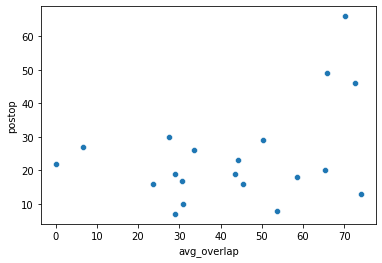

In [73]:
import seaborn as sns
sns.scatterplot(data=df3, x='avg_overlap', y='postop')

<AxesSubplot: xlabel='avg_overlap'>

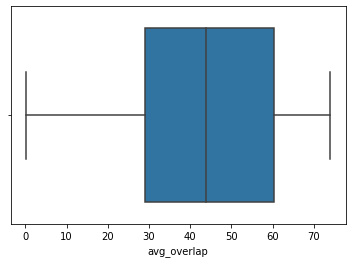

In [67]:
sns.boxplot(data=df3, x='avg_overlap')

In [60]:
path_3 = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/master.csv'
df3.to_csv(path_3)

In [64]:
df3['avg_overlap'] = (df3.loc[:, 'percent_overlap_l'] + df3.loc[:,'percent_overlap_r']) / 2

In [65]:
df3

,subid,baseline,postop,difference,percent_improve,percent_overlap_l,percent_overlap_r,avg_overlap,dice_coeff_r,dice_coeff_l,avg_dice
0,201,28,23,-5,17.857143,26.318290,62.022901,44.170595,0.752880,0.416159,0.584519
1,205,54,29,-25,46.296296,10.542666,90.102767,50.322716,0.338084,0.190744,0.264414
2,206,43,18,-25,58.139535,17.314488,100.000000,58.657244,0.105354,0.263198,0.184276
3,208,14,22,8,-57.142857,0.000000,0.239502,0.119751,0.004779,0.000000,0.002389
4,209,22,16,-6,27.272727,1.961209,88.982092,45.471651,0.260172,0.038470,0.149321
5,211,27,19,-8,29.629630,2.469591,84.531659,43.500625,0.519354,0.044906,0.282130
6,214,23,16,-7,30.434783,0.448754,46.703297,23.576025,0.396681,0.008686,0.202683
7,215,61,26,-35,57.377049,8.106525,58.899407,33.502966,0.627610,0.149973,0.388791
8,220,30,7,-23,76.666667,6.127491,51.863878,28.995685,0.679255,0.115385,0.397320
9,221,26,8,-18,69.230769,18.492702,88.815500,53.654101,0.356476,0.312092,0.334284
